# Data Perparation

In [1]:
!wget "https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download" -O english_python_data.txt 

--2021-03-18 07:59:00--  https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download
Resolving drive.google.com (drive.google.com)... 108.177.125.100, 108.177.125.113, 108.177.125.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l10lptuaiis9ahnlcjmkss508euj3pdd/1616054325000/02008525212197398114/*/1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO?e=download [following]
--2021-03-18 07:59:01--  https://doc-14-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l10lptuaiis9ahnlcjmkss508euj3pdd/1616054325000/02008525212197398114/*/1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO?e=download
Resolving doc-14-3o-docs.googleusercontent.com (doc-14-3o-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-14-3o-docs.googleusercontent.com

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, Iterator
from torchtext.legacy import data

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

In [3]:
torchtext.__version__

'0.9.0'

In [4]:
%set_env CUDA_LAUNCH_BLOCKING = 1

env: CUDA_LAUNCH_BLOCKING=1


## Reading the text file

In [5]:
f = open("english_python_data.txt", "r")
file_lines = f.readlines()

In [6]:
file_lines[:20]

['# write a python program to add two numbers \n',
 'num1 = 1.5\n',
 'num2 = 6.3\n',
 'sum = num1 + num2\n',
 "print(f'Sum: {sum}')\n",
 '\n',
 '\n',
 '# write a python function to add two user provided numbers and return the sum\n',
 'def add_two_numbers(num1, num2):\n',
 '    sum = num1 + num2\n',
 '    return sum\n',
 '\n',
 '\n',
 '# write a program to find and print the largest among three numbers\n',
 '\n',
 'num1 = 10\n',
 'num2 = 12\n',
 'num3 = 14\n',
 'if (num1 >= num2) and (num1 >= num3):\n',
 '   largest = num1\n']

Our dataset is formulated in a manner where every question starts with '#'. Lines between two consecutive '#' forms the solution to the question.

In [7]:
dps = []
dp = None
for line in file_lines:
  if line[0] == "#":
    if dp:
      dp['solution'] = ''.join(dp['solution'])
      dps.append(dp)
    dp = {"question": None, "solution": []}
    dp['question'] = line[1:]
  else:
    dp["solution"].append(line)

Lets take a look at the first 50 entries of the data we have parsed.

In [8]:
i=0
for dp in dps:
  print("\n Question no: ", i+1)
  i+=1
  print(dp['question'][1:])
  print(dp['solution'])
  if i>49:
    break


 Question no:  1
write a python program to add two numbers 

num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')




 Question no:  2
write a python function to add two user provided numbers and return the sum

def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum




 Question no:  3
write a program to find and print the largest among three numbers


num1 = 10
num2 = 12
num3 = 14
if (num1 >= num2) and (num1 >= num3):
   largest = num1
elif (num2 >= num1) and (num2 >= num3):
   largest = num2
else:
   largest = num3
print(f'largest:{largest}')




 Question no:  4
write a program to find and print the smallest among three numbers

num1 = 10
num2 = 12
num3 = 14
if (num1 <= num2) and (num1 <= num3):
   smallest = num1
elif (num2 <= num1) and (num2 <= num3):
   smallest = num2
else:
   smallest = num3
print(f'smallest:{smallest}')




 Question no:  5
Write a python function to merge two given lists into one

def merge_lists(l1, l2):
    return l1 + l2




 Quest

In [9]:
print("Dataset size:", len(dps))

Dataset size: 4957


## Using a custom tokenizer to tokenize python code

Python is a programming language with its own unique syntax. Regular tokenizers like spacy are meant to tokenize english scentences and are not optimized towards Python's syntax. Here, we write our own custom tokenizer that makes use of Python's default [tokenize](https://docs.python.org/3/library/tokenize.html) library. When we make use of this library we only extract the token type and the token string.  


In [10]:
from tokenize import tokenize, untokenize
import io


def tokenize_python_code(python_code_str):
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []
    for i in range(0, len(python_tokens)):
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    return tokenized_output


In [11]:
tokenized_sample = tokenize_python_code(dps[1]['solution'])
print(tokenized_sample)

[(57, 'utf-8'), (1, 'def'), (1, 'add_two_numbers'), (53, '('), (1, 'num1'), (53, ','), (1, 'num2'), (53, ')'), (53, ':'), (4, '\n'), (5, '    '), (1, 'sum'), (53, '='), (1, 'num1'), (53, '+'), (1, 'num2'), (4, '\n'), (1, 'return'), (1, 'sum'), (4, '\n'), (56, '\n'), (56, '\n'), (6, ''), (0, '')]


In [12]:
print(untokenize(tokenized_sample).decode('utf-8'))

def add_two_numbers (num1 ,num2 ):
    sum =num1 +num2 
    return sum 





Since we have mere 5000 data points, we make use of data augmentations to increase the size of our dataset. While tokenizing the python code, we mask the names of certain variables randomly(with 'var_1, 'var_2' etc) to ensure that the model that we train does not merly fixate on the way the variables are named and actually tries to understand the inhrent logic and syntax of the python code.

But, while randomly picking varibles to mask we avoid keyword literals(*keyword.kwlist*), control structures(as can be seen in below *skip_list*) and object properties. We add all such literals that need to be skipped into the *skip_list*

```skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']```


In [13]:
import keyword

print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']


In [14]:
def augment_tokenize_python_code(python_code_str, mask_factor=0.3):


    var_dict = {} # Dictionary that stores masked variables

    # certain reserved words that should not be treated as normal variables and
    # hence need to be skipped from our variable mask augmentations
    skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'zip'
                 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']
    skip_list.extend(keyword.kwlist)

    var_counter = 1
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []

    for i in range(0, len(python_tokens)):
      if python_tokens[i].type == 1 and python_tokens[i].string not in skip_list:
        
        if i>0 and python_tokens[i-1].string in ['def', '.', 'import', 'raise', 'except', 'class']: # avoid masking modules, functions and error literals
          skip_list.append(python_tokens[i].string)
          tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
        elif python_tokens[i].string in var_dict:  # if variable is already masked
          tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
        elif random.uniform(0, 1) > 1-mask_factor: # randomly mask variables
          var_dict[python_tokens[i].string] = 'var_' + str(var_counter)
          var_counter+=1
          tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
        else:
          skip_list.append(python_tokens[i].string)
          tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
      
      else:
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    
    return tokenized_output

In [15]:
tokenized_sample = augment_tokenize_python_code(dps[1]['solution'])
print(tokenized_sample)

[(57, 'utf-8'), (1, 'def'), (1, 'add_two_numbers'), (53, '('), (1, 'var_1'), (53, ','), (1, 'num2'), (53, ')'), (53, ':'), (4, '\n'), (5, '    '), (1, 'sum'), (53, '='), (1, 'var_1'), (53, '+'), (1, 'num2'), (4, '\n'), (1, 'return'), (1, 'sum'), (4, '\n'), (56, '\n'), (56, '\n'), (6, ''), (0, '')]


In [16]:
print(untokenize(tokenized_sample).decode('utf-8'))

def add_two_numbers (var_1 ,num2 ):
    sum =var_1 +num2 
    return sum 





As one can see our augmented tokenizer picked num2 randomly and masked(replaced) it with by var_1

## Building Train and Validation Dataset

In [17]:
python_problems_df = pd.DataFrame(dps)

In [18]:
python_problems_df.head()

,question,solution
0,write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provi...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
3,write a program to find and print the smalles...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given li...,"def merge_lists(l1, l2):\n return l1 + l2\n..."


In [19]:
python_problems_df.shape

(4957, 2)

In [20]:
import numpy as np

np.random.seed(0)
msk = np.random.rand(len(python_problems_df)) < 0.85 # Splitting data into 85% train and 15% validation

train_df = python_problems_df[msk]
val_df = python_problems_df[~msk]

In [21]:
train_df.shape

(4211, 2)

In [22]:
val_df.shape

(746, 2)

## Creating vocabulary using torchtext

In this section we will use torchtext Fields to construct the vocabulary for our sequence-to-sequence learning problem.  

In [23]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [24]:
Input = data.Field(tokenize = 'spacy',
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

Output = data.Field(tokenize = augment_tokenize_python_code,
                    init_token='<sos>', 
                    eos_token='<eos>', 
                    lower=False)

In [25]:
fields = [('Input', Input),('Output', Output)]

Since our data augmentations have the potential to increase the vocabulary beyond what it initially is, we must ensure that we capture as many variations as possible in the vocabulary that we develop. In the the below code we apply our data augmentations 100 times to ensure that we can capture a majority of augmentations into our vocabulary. 

In [26]:
train_example = []
val_example = []

train_expansion_factor = 100
for j in range(train_expansion_factor):
  for i in range(train_df.shape[0]):
      try:
          ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
          train_example.append(ex)
      except:
          pass

for i in range(val_df.shape[0]):
    try:
        ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
        val_example.append(ex)
    except:
        pass       

In [27]:
train_data = data.Dataset(train_example, fields)
valid_data =  data.Dataset(val_example, fields)

In [28]:
Input.build_vocab(train_data, min_freq = 0)
Output.build_vocab(train_data, min_freq = 0)

In [29]:
Output.vocab

In [30]:
def save_vocab(vocab, path):
    import pickle
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

In [31]:
# save_vocab(Input.vocab, "/content/drive/MyDrive/TheSchoolOfAI/EndCapstone/src_vocab.pkl")
# save_vocab(Output.vocab, "/content/drive/MyDrive/TheSchoolOfAI/EndCapstone/trg_vocab.pkl")

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
train_data[0].Output

[(57, 'utf-8'),
 (1, 'var_1'),
 (53, '='),
 (2, '1.5'),
 (4, '\n'),
 (1, 'num2'),
 (53, '='),
 (2, '6.3'),
 (4, '\n'),
 (1, 'sum'),
 (53, '='),
 (1, 'var_1'),
 (53, '+'),
 (1, 'num2'),
 (4, '\n'),
 (1, 'print'),
 (53, '('),
 (3, "f'Sum: {sum}'"),
 (53, ')'),
 (4, ''),
 (0, '')]

In [35]:
print(vars(train_data.examples[1]))

{'Input': [' ', 'write', 'a', 'python', 'function', 'to', 'add', 'two', 'user', 'provided', 'numbers', 'and', 'return', 'the', 'sum'], 'Output': [(57, 'utf-8'), (1, 'def'), (1, 'add_two_numbers'), (53, '('), (1, 'num1'), (53, ','), (1, 'var_1'), (53, ')'), (53, ':'), (4, '\n'), (5, '    '), (1, 'sum'), (53, '='), (1, 'num1'), (53, '+'), (1, 'var_1'), (4, '\n'), (1, 'return'), (1, 'sum'), (4, ''), (6, ''), (0, '')]}


# Transformer Architecture

Our transformer can be understood in terms of its three components:
1. An Encoder that encodes an input sequence into state representation vectors.
2. An Attention mechanism that enables our Transformer model to focus on the right aspects of the sequential input stream. This is used repeatedly within both the encoder and the decoder to help them contextualize the input data.
3. A Decoder that decodes the state representation vector to generate the target output sequence

## Encoder

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

Our Encoder accepts a batch of source sequences and sequence masks as input. The source mask contains 1 in locations where the input sequence has valid values and 0 where the input sequence has <pad> values. This ensures that the attention mechanism within the encoder does not pay attention to <pad> values.

We convert our source sequence tokens into embeddings(‘tok_embedding’) of ‘hid_dim’ length. Since were are not using any recurrent networks we need to tag each token with its positional indices in order to preserve sequential information. We create an indices tensor(i.e. ‘pos’) and convert this into an embedding(‘pos_embedding’) of length ‘hid_dim’. This is combined with the source sequence embeddings to create our initial Encoder Layer input tensor src. This src tensor is passed through a series of Encoder Layers.

In [37]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

An EncoderLayer is the basic building block of our Transformer’s Encoder component. Our src tensor along with its ‘src_mask’ are sent into a multi-head self-attention operation to help our model focus on the necessary aspects of the src tensor. The output from the attention operation is combined with the src tensor(via skip connection) and normalized to avoid vanishing/exploding gradients(during training). This combined output is sent into a PositionwiseFeedForwardLayer.

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

A PositionwiseFeedForwardLayer takes the combined input and processes it further using two fully connected layers and a Relu activation function between them. This in combination with the src embedding is the final output of an EncoderLayer. This process repeats for each EncoderLayer block.


In [39]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

## Attention

Attention is a mechanism that allows a model to focus on the necessary parts of the input sequence as per the demands of the task at hand.

Researchers at google like to look at everything as an information retrieval problem. Therefore the [“Attention is all you need”](https://arxiv.org/abs/1706.03762) paper tries to look at attention in terms of “Query”, “Keys” and “Values”. A search engine accepts a “Query” and tries to match it up with Indices(i.e. Keys) in order to get appropriate values as results for the query. Similarly one can think of attention as a mechanism in which the query vector and key vector work towards getting the right attention weights(i.e. values).

When multiple channels(or heads) of attention are applied in parallel to a single source, it is known as multi-head attention. This increases the learning capacity of the model and therefore leads to better results.

In [40]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

## Decoder

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

The architecture of a Decoder is very similar to that of the encoder with the significant differences resulting from the presence of input from two sources, the target sequence and the state representation vector from the encoder. Much like how we had an EncoderLayer block for Encoder, we will be having a DecoderLayer that accepts as input the combination of the embedding from the target token sequence(tok_embedding) and embedding of positional indices for these tokens. And as mentioned earlier, the encoder’s output also acts as one of the inputs to the DecoderLayer.

In [41]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

The DecoderLayer forms the building block of our Transformer’s decoder. Each DecoderLayer involves two attention operations:
1. Self-attention on trg embedding.
2. Multi-head attention operation that uses the trg as query vector and the encoder outputs act as the key and value vectors.

The presence of an extra Multi-head attention operation differentiates the DecoderLayer from an EncoderLayer.

The attention outputs from self-attention are normalized and combined with the trg embedding using a residual connection. This is then sent into the multi-head attention operation along with the encoder outputs. The attention layer outputs are then combined with the trg input again and normalized before sending it into the position-wise feedforward layer to generate the final outputs of the DecoderLayer.

The purpose of all normalization operations is to prevent vanishing/exploding gradients during training.

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

The main class that implements a transformer for seq2seq problems is given below.


In [43]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Training

In [44]:
INPUT_DIM = len(Input.vocab)
OUTPUT_DIM = len(Output.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 16
DEC_HEADS = 16
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [45]:
len(Output.vocab.__dict__['freqs'])

5666

In [46]:
SRC_PAD_IDX = Input.vocab.stoi[Input.pad_token]
TRG_PAD_IDX = Output.vocab.stoi[Output.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,219,558 trainable parameters


In [48]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [49]:
model.apply(initialize_weights);

In [50]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

## Loss function

We have used augmentations in our dataset to mask variable literals. This means that our model can predict a variety of values for a particular variable and all of them are correct as long as the predictions are consistent through the code. This would mean that our training labels are not very certain and hence it would make more sense to treat them to be correct with probability ```1- smooth_eps``` and incorrect otherwise. This is what label smoothening enables us to do. The following is the implementation of CrossEntropyLoss with label smoothening.

In [51]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss(nn.CrossEntropyLoss):
    """CrossEntropyLoss - with ability to recieve distrbution as targets, and optional label smoothing"""

    def __init__(self, weight=None, ignore_index=-100, reduction='mean', smooth_eps=None, smooth_dist=None, from_logits=True):
        super(CrossEntropyLoss, self).__init__(weight=weight,
                                               ignore_index=ignore_index, reduction=reduction)
        self.smooth_eps = smooth_eps
        self.smooth_dist = smooth_dist
        self.from_logits = from_logits

    def forward(self, input, target, smooth_dist=None):
        if smooth_dist is None:
            smooth_dist = self.smooth_dist
        return cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index,
                             reduction=self.reduction, smooth_eps=self.smooth_eps,
                             smooth_dist=smooth_dist, from_logits=self.from_logits)


def cross_entropy(inputs, target, weight=None, ignore_index=-100, reduction='mean',
                  smooth_eps=None, smooth_dist=None, from_logits=True):
    """cross entropy loss, with support for target distributions and label smoothing https://arxiv.org/abs/1512.00567"""
    smooth_eps = smooth_eps or 0

    # ordinary log-liklihood - use cross_entropy from nn
    if _is_long(target) and smooth_eps == 0:
        if from_logits:
            return F.cross_entropy(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)
        else:
            return F.nll_loss(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)

    if from_logits:
        # log-softmax of inputs
        lsm = F.log_softmax(inputs, dim=-1)
    else:
        lsm = inputs

    masked_indices = None
    num_classes = inputs.size(-1)

    if _is_long(target) and ignore_index >= 0:
        masked_indices = target.eq(ignore_index)

    if smooth_eps > 0 and smooth_dist is not None:
        if _is_long(target):
            target = onehot(target, num_classes).type_as(inputs)
        if smooth_dist.dim() < target.dim():
            smooth_dist = smooth_dist.unsqueeze(0)
        target.lerp_(smooth_dist, smooth_eps)

    if weight is not None:
        lsm = lsm * weight.unsqueeze(0)

    if _is_long(target):
        eps_sum = smooth_eps / num_classes
        eps_nll = 1. - eps_sum - smooth_eps
        likelihood = lsm.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1)
        loss = -(eps_nll * likelihood + eps_sum * lsm.sum(-1))
    else:
        loss = -(target * lsm).sum(-1)

    if masked_indices is not None:
        loss.masked_fill_(masked_indices, 0)

    if reduction == 'sum':
        loss = loss.sum()
    elif reduction == 'mean':
        if masked_indices is None:
            loss = loss.mean()
        else:
            loss = loss.sum() / float(loss.size(0) - masked_indices.sum())

    return loss


def onehot(indexes, N=None, ignore_index=None):
    """
    Creates a one-representation of indexes with N possible entries
    if N is not specified, it will suit the maximum index appearing.
    indexes is a long-tensor of indexes
    ignore_index will be zero in onehot representation
    """
    if N is None:
        N = indexes.max() + 1
    sz = list(indexes.size())
    output = indexes.new().byte().resize_(*sz, N).zero_()
    output.scatter_(-1, indexes.unsqueeze(-1), 1)
    if ignore_index is not None and ignore_index >= 0:
        output.masked_fill_(indexes.eq(ignore_index).unsqueeze(-1), 0)
    return output

def _is_long(x):
    if hasattr(x, 'data'):
        x = x.data
    return isinstance(x, torch.LongTensor) or isinstance(x, torch.cuda.LongTensor)


In [52]:
def maskNLLLoss(inp, target, mask):
    # print(inp.shape, target.shape, mask.sum())
    nTotal = mask.sum()
    crossEntropy = CrossEntropyLoss(ignore_index = TRG_PAD_IDX, smooth_eps=0.20)
    loss = crossEntropy(inp, target)
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
criterion = maskNLLLoss

## Training

In order to re-apply our augmentations differently in every epoch we re-create our dataset and dataloaders at the start of each epoch. This regularizes our training process and helps us come up with better models.

In [ ]:
from tqdm import tqdm

def make_trg_mask(trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != TRG_PAD_IDX).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    n_totals = 0
    print_losses = []
    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
        # print(batch)
        loss = 0
        src = batch.Input.permute(1, 0)
        trg = batch.Output.permute(1, 0)
        trg_mask = make_trg_mask(trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        mask_loss, nTotal = criterion(output, trg, trg_mask)
        
        mask_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal


        
    return sum(print_losses) / n_totals

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    n_totals = 0
    print_losses = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

            src = batch.Input.permute(1, 0)
            trg = batch.Output.permute(1, 0)
            trg_mask = make_trg_mask(trg)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            mask_loss, nTotal = criterion(output, trg, trg_mask)

            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

        
    return sum(print_losses) / n_totals

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_example = []
    val_example = []

    for i in range(train_df.shape[0]):
        try:
            ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
            train_example.append(ex)
        except:
            pass

    for i in range(val_df.shape[0]):
        try:
            ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
            val_example.append(ex)
        except:
            pass       

    train_data = data.Dataset(train_example, fields)
    valid_data =  data.Dataset(val_example, fields)

    BATCH_SIZE = 16
    train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                                sort_key = lambda x: len(x.Input),
                                                                sort_within_batch=True, device = device)

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/TheSchoolOfAI/EndCapstone/model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 8/8 [00:00<00:00, 67.25it/s]


Epoch: 01 | Time: 0m 18s
	Train Loss: 5.012 | Train PPL: 150.185
	 Val. Loss: 4.344 |  Val. PPL:  76.984


100%|██████████| 8/8 [00:00<00:00, 59.14it/s]


Epoch: 02 | Time: 0m 17s
	Train Loss: 4.188 | Train PPL:  65.858
	 Val. Loss: 4.118 |  Val. PPL:  61.412


100%|██████████| 8/8 [00:00<00:00, 68.90it/s]


Epoch: 03 | Time: 0m 17s
	Train Loss: 3.961 | Train PPL:  52.523
	 Val. Loss: 3.961 |  Val. PPL:  52.495


100%|██████████| 8/8 [00:00<00:00, 68.04it/s]


Epoch: 04 | Time: 0m 17s
	Train Loss: 3.807 | Train PPL:  45.018
	 Val. Loss: 3.890 |  Val. PPL:  48.890


100%|██████████| 8/8 [00:00<00:00, 64.11it/s]


Epoch: 05 | Time: 0m 17s
	Train Loss: 3.688 | Train PPL:  39.957
	 Val. Loss: 3.808 |  Val. PPL:  45.056


100%|██████████| 8/8 [00:00<00:00, 64.50it/s]


Epoch: 06 | Time: 0m 17s
	Train Loss: 3.587 | Train PPL:  36.114
	 Val. Loss: 3.764 |  Val. PPL:  43.119


100%|██████████| 8/8 [00:00<00:00, 68.72it/s]


Epoch: 07 | Time: 0m 17s
	Train Loss: 3.488 | Train PPL:  32.709
	 Val. Loss: 3.695 |  Val. PPL:  40.227


100%|██████████| 8/8 [00:00<00:00, 67.64it/s]


Epoch: 08 | Time: 0m 17s
	Train Loss: 3.410 | Train PPL:  30.255
	 Val. Loss: 3.669 |  Val. PPL:  39.203


100%|██████████| 8/8 [00:00<00:00, 64.55it/s]


Epoch: 09 | Time: 0m 17s
	Train Loss: 3.336 | Train PPL:  28.098
	 Val. Loss: 3.670 |  Val. PPL:  39.247


100%|██████████| 8/8 [00:00<00:00, 66.30it/s]


Epoch: 10 | Time: 0m 17s
	Train Loss: 3.271 | Train PPL:  26.329
	 Val. Loss: 3.613 |  Val. PPL:  37.059


100%|██████████| 8/8 [00:00<00:00, 66.84it/s]


Epoch: 11 | Time: 0m 17s
	Train Loss: 3.212 | Train PPL:  24.824
	 Val. Loss: 3.581 |  Val. PPL:  35.902


100%|██████████| 8/8 [00:00<00:00, 68.20it/s]


Epoch: 12 | Time: 0m 17s
	Train Loss: 3.169 | Train PPL:  23.775
	 Val. Loss: 3.572 |  Val. PPL:  35.576


100%|██████████| 8/8 [00:00<00:00, 66.91it/s]


Epoch: 13 | Time: 0m 17s
	Train Loss: 3.115 | Train PPL:  22.523
	 Val. Loss: 3.528 |  Val. PPL:  34.068


100%|██████████| 8/8 [00:00<00:00, 66.85it/s]


Epoch: 14 | Time: 0m 17s
	Train Loss: 3.072 | Train PPL:  21.593
	 Val. Loss: 3.586 |  Val. PPL:  36.076


100%|██████████| 8/8 [00:00<00:00, 69.80it/s]


Epoch: 15 | Time: 0m 17s
	Train Loss: 3.039 | Train PPL:  20.894
	 Val. Loss: 3.520 |  Val. PPL:  33.800


100%|██████████| 8/8 [00:00<00:00, 65.89it/s]


Epoch: 16 | Time: 0m 17s
	Train Loss: 3.005 | Train PPL:  20.185
	 Val. Loss: 3.521 |  Val. PPL:  33.818


100%|██████████| 8/8 [00:00<00:00, 66.03it/s]


Epoch: 17 | Time: 0m 17s
	Train Loss: 2.980 | Train PPL:  19.690
	 Val. Loss: 3.504 |  Val. PPL:  33.251


100%|██████████| 8/8 [00:00<00:00, 65.62it/s]


Epoch: 18 | Time: 0m 17s
	Train Loss: 2.945 | Train PPL:  19.013
	 Val. Loss: 3.502 |  Val. PPL:  33.174


100%|██████████| 8/8 [00:00<00:00, 64.13it/s]


Epoch: 19 | Time: 0m 17s
	Train Loss: 2.921 | Train PPL:  18.552
	 Val. Loss: 3.497 |  Val. PPL:  33.005


100%|██████████| 8/8 [00:00<00:00, 66.15it/s]


Epoch: 20 | Time: 0m 17s
	Train Loss: 2.902 | Train PPL:  18.206
	 Val. Loss: 3.496 |  Val. PPL:  32.995


100%|██████████| 8/8 [00:00<00:00, 65.77it/s]


Epoch: 21 | Time: 0m 17s
	Train Loss: 2.882 | Train PPL:  17.852
	 Val. Loss: 3.463 |  Val. PPL:  31.915


100%|██████████| 8/8 [00:00<00:00, 69.05it/s]


Epoch: 22 | Time: 0m 17s
	Train Loss: 2.857 | Train PPL:  17.403
	 Val. Loss: 3.466 |  Val. PPL:  32.022


100%|██████████| 8/8 [00:00<00:00, 69.14it/s]


Epoch: 23 | Time: 0m 17s
	Train Loss: 2.844 | Train PPL:  17.193
	 Val. Loss: 3.453 |  Val. PPL:  31.589


100%|██████████| 8/8 [00:00<00:00, 68.60it/s]


Epoch: 24 | Time: 0m 17s
	Train Loss: 2.828 | Train PPL:  16.905
	 Val. Loss: 3.471 |  Val. PPL:  32.178


100%|██████████| 8/8 [00:00<00:00, 69.64it/s]


Epoch: 25 | Time: 0m 17s
	Train Loss: 2.803 | Train PPL:  16.501
	 Val. Loss: 3.462 |  Val. PPL:  31.876


100%|██████████| 8/8 [00:00<00:00, 69.04it/s]


Epoch: 26 | Time: 0m 17s
	Train Loss: 2.799 | Train PPL:  16.422
	 Val. Loss: 3.473 |  Val. PPL:  32.229


100%|██████████| 8/8 [00:00<00:00, 67.66it/s]


Epoch: 27 | Time: 0m 17s
	Train Loss: 2.785 | Train PPL:  16.194
	 Val. Loss: 3.443 |  Val. PPL:  31.295


100%|██████████| 8/8 [00:00<00:00, 66.72it/s]


Epoch: 28 | Time: 0m 17s
	Train Loss: 2.768 | Train PPL:  15.919
	 Val. Loss: 3.446 |  Val. PPL:  31.361


100%|██████████| 8/8 [00:00<00:00, 67.83it/s]


Epoch: 29 | Time: 0m 17s
	Train Loss: 2.760 | Train PPL:  15.792
	 Val. Loss: 3.430 |  Val. PPL:  30.869


100%|██████████| 8/8 [00:00<00:00, 66.02it/s]


Epoch: 30 | Time: 0m 17s
	Train Loss: 2.749 | Train PPL:  15.632
	 Val. Loss: 3.469 |  Val. PPL:  32.090


100%|██████████| 8/8 [00:00<00:00, 65.22it/s]


Epoch: 31 | Time: 0m 17s
	Train Loss: 2.728 | Train PPL:  15.304
	 Val. Loss: 3.427 |  Val. PPL:  30.787


100%|██████████| 8/8 [00:00<00:00, 63.28it/s]


Epoch: 32 | Time: 0m 17s
	Train Loss: 2.729 | Train PPL:  15.321
	 Val. Loss: 3.458 |  Val. PPL:  31.752


100%|██████████| 8/8 [00:00<00:00, 68.51it/s]


Epoch: 33 | Time: 0m 17s
	Train Loss: 2.716 | Train PPL:  15.122
	 Val. Loss: 3.428 |  Val. PPL:  30.816


100%|██████████| 8/8 [00:00<00:00, 63.22it/s]


Epoch: 34 | Time: 0m 17s
	Train Loss: 2.709 | Train PPL:  15.018
	 Val. Loss: 3.448 |  Val. PPL:  31.431


100%|██████████| 8/8 [00:00<00:00, 66.97it/s]


Epoch: 35 | Time: 0m 17s
	Train Loss: 2.692 | Train PPL:  14.767
	 Val. Loss: 3.466 |  Val. PPL:  32.016


100%|██████████| 8/8 [00:00<00:00, 68.74it/s]


Epoch: 36 | Time: 0m 17s
	Train Loss: 2.682 | Train PPL:  14.616
	 Val. Loss: 3.432 |  Val. PPL:  30.945


100%|██████████| 8/8 [00:00<00:00, 64.81it/s]


Epoch: 37 | Time: 0m 17s
	Train Loss: 2.687 | Train PPL:  14.693
	 Val. Loss: 3.431 |  Val. PPL:  30.916


100%|██████████| 8/8 [00:00<00:00, 66.36it/s]


Epoch: 38 | Time: 0m 17s
	Train Loss: 2.671 | Train PPL:  14.454
	 Val. Loss: 3.443 |  Val. PPL:  31.286


100%|██████████| 8/8 [00:00<00:00, 69.40it/s]


Epoch: 39 | Time: 0m 17s
	Train Loss: 2.663 | Train PPL:  14.342
	 Val. Loss: 3.425 |  Val. PPL:  30.710


100%|██████████| 8/8 [00:00<00:00, 67.79it/s]


Epoch: 40 | Time: 0m 17s
	Train Loss: 2.660 | Train PPL:  14.300
	 Val. Loss: 3.396 |  Val. PPL:  29.839


100%|██████████| 8/8 [00:00<00:00, 68.86it/s]


Epoch: 41 | Time: 0m 17s
	Train Loss: 2.653 | Train PPL:  14.202
	 Val. Loss: 3.440 |  Val. PPL:  31.200


100%|██████████| 8/8 [00:00<00:00, 66.56it/s]


Epoch: 42 | Time: 0m 17s
	Train Loss: 2.644 | Train PPL:  14.067
	 Val. Loss: 3.415 |  Val. PPL:  30.403


100%|██████████| 8/8 [00:00<00:00, 59.68it/s]


Epoch: 43 | Time: 0m 17s
	Train Loss: 2.637 | Train PPL:  13.966
	 Val. Loss: 3.426 |  Val. PPL:  30.745


100%|██████████| 8/8 [00:00<00:00, 66.31it/s]


Epoch: 44 | Time: 0m 17s
	Train Loss: 2.635 | Train PPL:  13.943
	 Val. Loss: 3.432 |  Val. PPL:  30.950


100%|██████████| 8/8 [00:00<00:00, 64.76it/s]


Epoch: 45 | Time: 0m 17s
	Train Loss: 2.623 | Train PPL:  13.772
	 Val. Loss: 3.437 |  Val. PPL:  31.104


100%|██████████| 8/8 [00:00<00:00, 62.39it/s]


Epoch: 46 | Time: 0m 17s
	Train Loss: 2.624 | Train PPL:  13.795
	 Val. Loss: 3.416 |  Val. PPL:  30.458


100%|██████████| 8/8 [00:00<00:00, 66.47it/s]


Epoch: 47 | Time: 0m 17s
	Train Loss: 2.617 | Train PPL:  13.697
	 Val. Loss: 3.461 |  Val. PPL:  31.863


100%|██████████| 8/8 [00:00<00:00, 67.28it/s]


Epoch: 48 | Time: 0m 17s
	Train Loss: 2.614 | Train PPL:  13.652
	 Val. Loss: 3.418 |  Val. PPL:  30.502


100%|██████████| 8/8 [00:00<00:00, 67.54it/s]


Epoch: 49 | Time: 0m 17s
	Train Loss: 2.604 | Train PPL:  13.520
	 Val. Loss: 3.393 |  Val. PPL:  29.749


100%|██████████| 8/8 [00:00<00:00, 67.63it/s]

Epoch: 50 | Time: 0m 17s
	Train Loss: 2.606 | Train PPL:  13.545
	 Val. Loss: 3.458 |  Val. PPL:  31.756


In [59]:
SRC = Input
TRG = Output

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/TheSchoolOfAI/EndCapstone/model.pt'))

<All keys matched successfully>

In [56]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50000):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

## Displaying Attention

In [57]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(30,50))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
src = "write a function that adds two numbers"
src=src.split(" ")
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg sequence: ')
print(translation)
print("code: \n", untokenize(translation[:-1]).decode('utf-8'))

predicted trg sequence: 
[(57, 'utf-8'), (1, 'def'), (1, 'add'), (53, '('), (1, 'x'), (53, ','), (1, 'y'), (53, ')'), (53, ':'), (4, '\n'), (5, '    '), (1, 'return'), (1, 'x'), (53, '+'), (1, 'y'), (4, ''), (6, ''), (0, ''), '<eos>']
code: 
 def add (x ,y ):
    return x +y 


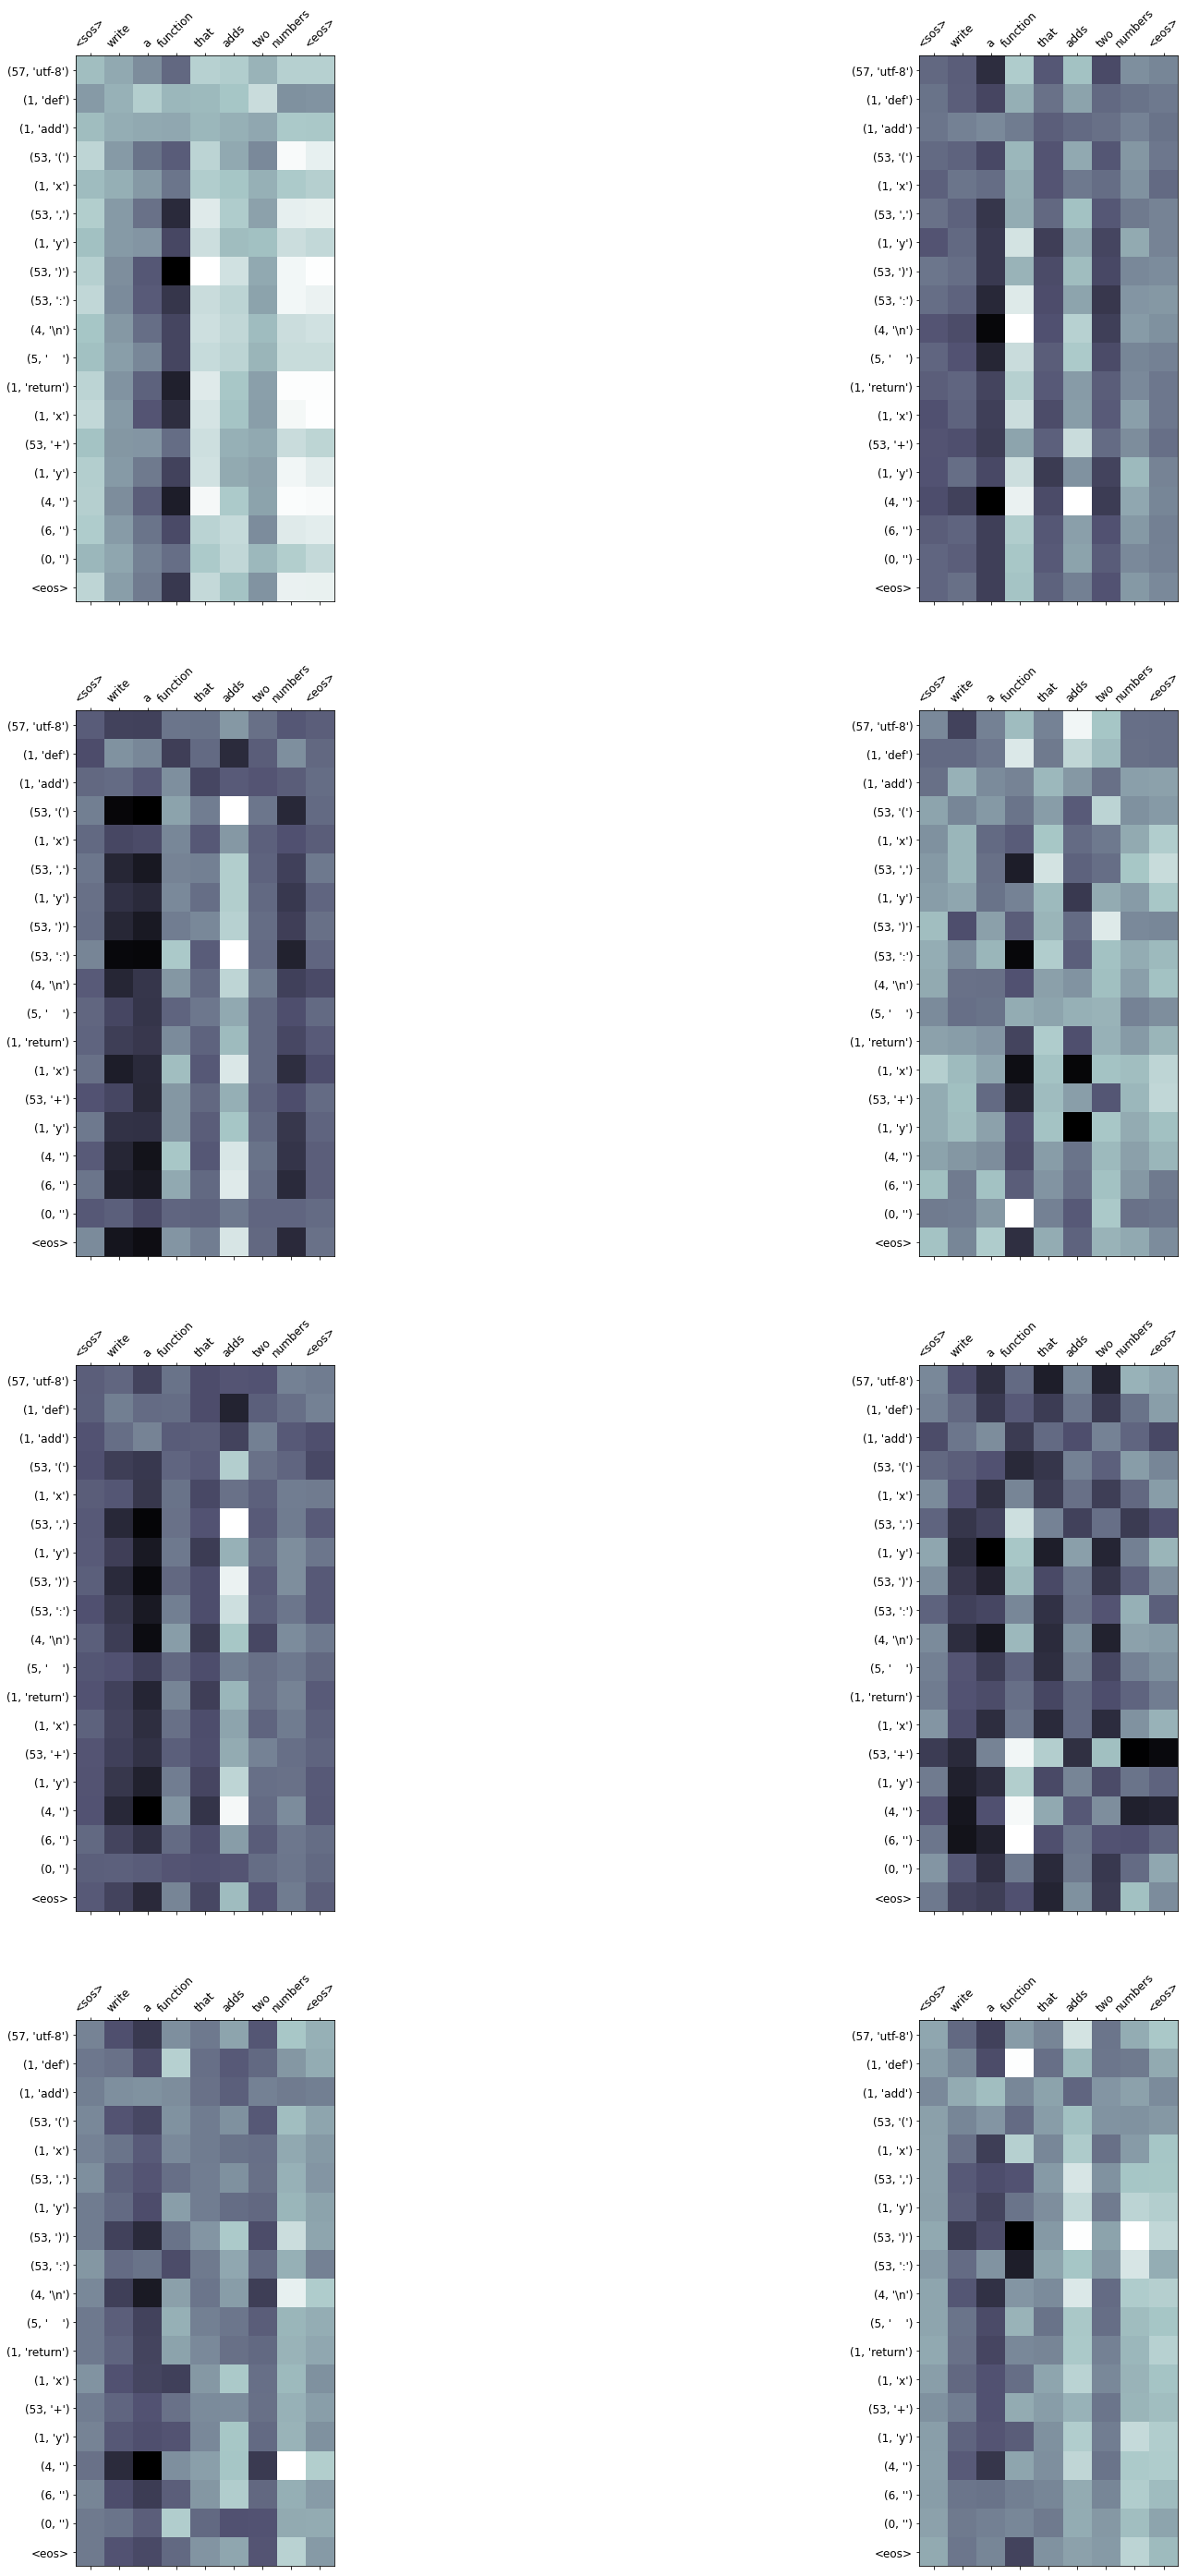

In [ ]:
display_attention(src, translation, attention)


# Sample Outputs for English to Python translation.

Lets load our pretrained model to perform inference on a set of examples

In [53]:
model.load_state_dict(torch.load('/content/drive/MyDrive/TheSchoolOfAI/EndCapstone/model_ep_0_pt_2.pt'))

<All keys matched successfully>

Function that translates an English src string to python code.

In [54]:
def eng_to_python(src):
  src=src.split(" ")
  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted trg: \n')
  # print(translation)
  print(untokenize(translation[:-1]).decode('utf-8'))


In [60]:
SRC = Input
TRG = Output

## Example 1

In [61]:
src = "program to sort a list of dictionaries by key"

eng_to_python(src)

predicted trg: 

var_1 ={'Nikhil':{'roll':24 ,'marks':17 },
'Akshat':{'roll':54 ,'marks':12 },
'Akash':{'roll':15 },'marks':15 }}
sort_key ='marks'
res ='marks'
res =var_2 (test_dict .items (),key =lambda x :x [1 ][sort_key ])
print ("The sorted dictionary by marks is : "+str (res ))


## Example 2

In [62]:
src = "function to merge two lists"

eng_to_python(src)

predicted trg: 

def merge_lists (l1 :list ,var_1 :list ):
    return list (zip (l1 ,var_1 ))


## Example 3

In [63]:
src = "program to find gcd"

eng_to_python(src)

predicted trg: 


def compute_hcf (x ,y ):

   while (y ):
       x ,y =y ,x %y 
   return x 


## Example 4

In [64]:
src = "program to calculate simple interest"

eng_to_python(src)

predicted trg: 


princ_amount =float (input (" Please Enter the Principal Amount : "))
var_1 =float (input (" Please Enter the Rate Of Interest   : "))
var_2 =float (input (" Please Enter Time period in Years   : "))

simple_interest =(princ_amount *var_1 *var_2 )/100 

print ("\nSimple Interest for Principal Amount {0} = {1}".format (princ_amount ,simple_interest ))


## Example 5

In [65]:
src = "function to sum odd elements of list"

eng_to_python(src)

predicted trg: 

def sum_odd_elements (l :list ):
    return sum ([i for i in l if i %2 ==1 ])


## Example 6

In [69]:
src = "program to multiply integers in a list"

eng_to_python(src)

predicted trg: 


def multiplyList (myList ):
    result =1 
    for x in myList :
         result =result *x 
    return result 




## Example 7

In [ ]:
src = "program to reverse a string"

eng_to_python(src)

predicted trg: 


var_1 ='Today is bad day'
var_1 [::-1 ]


## Example 8

In [ ]:
src = "function to find reverse of a string"

eng_to_python(src)

predicted trg: 


def revStr (inp ):
  inp =inp [::-1 ]
  return inp 


## Example 9

In [70]:
src = "program to find the length of tuple"

eng_to_python(src)

predicted trg: 

thistuple =("apple","banana","cherry")
print (len (thistuple ))


## Example 10

In [ ]:
src = "program to find the area of a square"

eng_to_python(src)

predicted trg: 

side =5 
print (f'Area: {side * side}')


## Example 11

In [ ]:
src = "program to print epoch timestamp"

eng_to_python(src)

predicted trg: 

import time 
import datetime 
str1 ="20/01/2020"
element =datetime .strptime (str1 ,"%d/%m/%Y")
timestamp =datetime .timestamp (element )
print (timestamp )


## Example 12

In [ ]:
src = "program to find ascii value of charecter"

eng_to_python(src)

predicted trg: 


var_1 ='5'
print (ord (var_1 ))


## Example 13

In [ ]:
src = "function to find fibonacci sequence"

eng_to_python(src)

predicted trg: 

def recur_fibo (n ):
   if n <=1 :
       return n 
   else :
       return (recur_fibo (n -1 )+recur_fibo (n -2 ))




## Example 14

In [72]:
src = "function to find largest element in a dictionary"

eng_to_python(src)

predicted trg: 


def dic_largest (var_1 ):
    return max (var_1 .values ())


## Example 15

In [ ]:
src = "program to convert list of tuples into a dictionary"

eng_to_python(src)

predicted trg: 

var_1 =[("x",1 ),("x",2 ),("y",1 ),("y",1 ),("y",2 ),("z",1 )]
d ={}
for a ,var_2 in var_1 :
    d .setdefault (a ,[]).append (var_2 )
print (d )


## Example 16

In [ ]:
src = "function to convert to binary"

eng_to_python(src)

predicted trg: 

def convertToBinary (n ):
   if n >1 :
       convertToBinary (n //2 )
   print (n %2 ,end ='')


## Example 17

In [ ]:
src = "program to implement a linked list"

eng_to_python(src)

predicted trg: 


class Node :

    def __init__ (self ,data ):
        self .data =data 
        self .next =None 

class LinkedList :

    def __init__ (self ):
        self .head =None 

    def reverse (self ):
        prev =None 
        current =self .next 
        while (current is not None ):
            next =current .next 
            current =current =current 
            current =current 
            current =current 
        self .next =current 

    def push (self ,new_data ):
        next =Node (new_data )
        self .next =self .next =self .next 

    def printList (self ):
        temp =self .head =temp 
        while (temp ):
            print (temp )
            temp =temp =temp .next 


llist =LinkedList ()
llist .push (20 )
llist .push (4 )
llist .push (15 )
llist .push (85 )

print ("Given Linked List")
llist .printList ()
llist .printList ()
llist .printList ()
llist .printList ("\nReversed Linked List")
llist .printList ()


## Example 18

In [73]:
src = "program to add lists elementwise"

eng_to_python(src)

predicted trg: 

var_1 =[1 ,2 ,3 ,4 ,5 ]
list2 =[5 ,6 ,7 ]
final =[a +b for a in var_1 for b in var_1 ]
print (f"sum of every pair of numbers from two lists:{final}")


## Example 19

In [ ]:
src = "program to find common values between two sets"

eng_to_python(src)

predicted trg: 


var_1 ={10 ,20 ,30 ,40 ,50 }
set2 ={60 ,70 ,80 ,90 ,10 }
if var_1 ==1 :
    print ("Two sets have no items in common")
else :
  print ("Two sets have items in common")
  print (var_1 .intersection (y ))


## Example 20

In [ ]:
src = "program to find number of unique values in a list"

eng_to_python(src)

predicted trg: 

input_list =[1 ,2 ,2 ,5 ,4 ,4 ,3 ,8 ]

var_1 =[]

for var_2 in input_list :
    if var_2 not in var_1 :
        var_1 +=1 

print ("No of unique items are:",var_1 )


## Example 21

In [ ]:
src = "function to remove empty lists from a list of lists"

eng_to_python(src)

predicted trg: 

def removeEmptyList (li ):
  res =[ele for ele in li if ele !=[]]
  return res 


## Example 22

In [ ]:
src = "write a function to capitalize a string"

eng_to_python(src)

predicted trg: 


def capitalize (text ):
    return text .title ()


## Example 23

In [ ]:
src = "write a function to find the area of a circle"

eng_to_python(src)

predicted trg: 

def circle_area (r ):
    return 22 /7 *r **2 


## Example 24

In [ ]:
src = "write a python program to merge two dictionaries"

eng_to_python(src)

predicted trg: 

x ={'key1':'val1','key2':'val2'}
y ={'key3':'val3','key4':'val4'}
z ={**x ,**y }# z = x | y  


## Example 25

In [ ]:
src = "write a function to find factorial"

eng_to_python(src)

predicted trg: 

def factorial (n ):
    if n ==0 :
        return 1 
    else :
        return n *factorial (n -1 )
